# **Generate training dataset:** Learning for super-resolution phase imaging

In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib notebook

import os, sys
import argparse
import time
from datetime import datetime
import scipy.io as sio

import numpy as np
import torch
from torch.utils.tensorboard import SummaryWriter

import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import matplotlib as mpl
mpl.rc('image', cmap='bone')

# import local experiment files
sys.path.append('./source/')
import dataloader
import visualizer
import model
from recon import evaluate
from utility import getAbs, getPhase
import pytorch_complex

# Setup device
os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"
device_no = 1
torch.cuda.set_device(device_no)
device = torch.device("cuda:"+str(device_no) if torch.cuda.is_available() else "cpu")

## System parameters to simulate the dataset

In [2]:
# small scale example
wl = 0.532
mag = 4
sys_mag = 1
ps = 6.5
na = 0.2
na_illum = 2.1*na
z_offset = 0
Np = [40, 40]

# cartesian dome 
### UPDATE THIS PATH FOR YOUR DATA PATH ###
loaddict = sio.loadmat('../../DATA/exp_mc_phase_usaf_2018_11_23/USAF_phase_dataset.mat') # has different LED positions than the amplitude one....
# loaddict = sio.loadmat('../../DATA/exp_mc_amp_usaf_2018_11_23/USAF_amplitude_dataset.mat')
na_list = np.asarray([loaddict['na_y_list'][0],loaddict['na_x_list'][0]]).transpose()

In [3]:
volume = np.prod(Np)
ckpt_size = np.round(volume * 2 * 4 / 1024**2, 2)
print('Single Ckpt:', ckpt_size, 'MB')

Single Ckpt: 0.01 MB


Bright Field: 21
Dark Field: 68
Total LEDs: 89


<IPython.core.display.Javascript object>


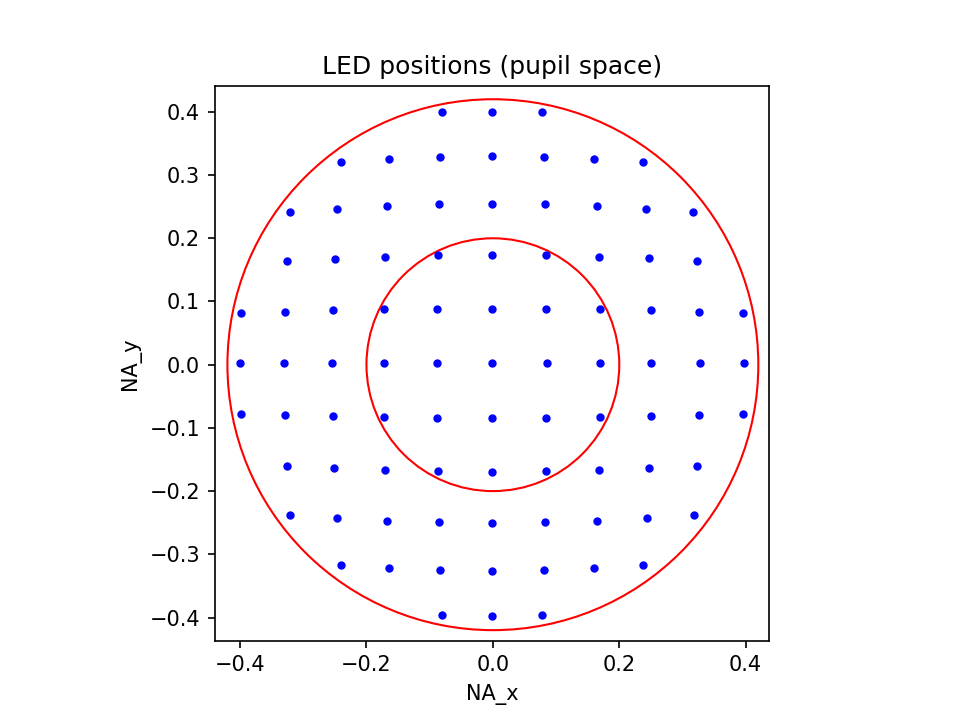

In [4]:
def dist2(nalist):
    return np.sqrt((nalist[:,0])**2 + (nalist[:,1])**2)
distlist = dist2(na_list)

bfmask = distlist < na
bfleds = na_list[bfmask,:]
Nbfleds = np.sum(bfmask)
print('Bright Field:',np.sum(bfmask))

dfmask = (distlist < na_illum) & (distlist > na)
dfleds = na_list[dfmask,:]
Ndfleds = np.sum(dfmask)
print('Dark Field:',np.sum(dfmask))

Nleds = Nbfleds + Ndfleds
print('Total LEDs:',Nleds)
pruned_na_list = na_list[:Nleds,:]

fig, ax = plt.subplots()
plt.plot(pruned_na_list[:,0],pruned_na_list[:,1],'b.')
plt.xlabel('NA_x'), plt.ylabel('NA_y'), plt.title('LED positions (pupil space)')
circle1 = plt.Circle((0, 0), na, color=None, edgecolor='r', fill=False)
circle2 = plt.Circle((0, 0), na_illum, color=None, edgecolor='r', fill=False)
ax.add_artist(circle1)
ax.add_artist(circle2)
ax.set_aspect('equal')

## Setup model to simulate measurements

In [13]:
metadata = {'Np': Np,
            'mag': mag,
            'wl': wl,
            'na': na,
            'na_illum': na_illum,
            'ps': ps,
            'na_list': pruned_na_list,
            'Nleds': Nleds,
            'z_offset': z_offset,
            'NbfLEDs': Nbfleds,
            'NdfLEDs': Ndfleds,
            'num_meas': Nleds,
            'num_bf': Nbfleds,
            'num_df': Ndfleds,
            'alpha': 5e-2,
            'num_unrolls': 100,
            'T': 4,
           }
network = model.model(metadata, device = device)
network.network = network.network.to(device)

Reconstruction's pixel size (um): 0.42903225806451606
System's pixel size limit (um): 1.33
Camera's effective pixel size (um): 1.625


## Load image for simulation

<IPython.core.display.Javascript object>


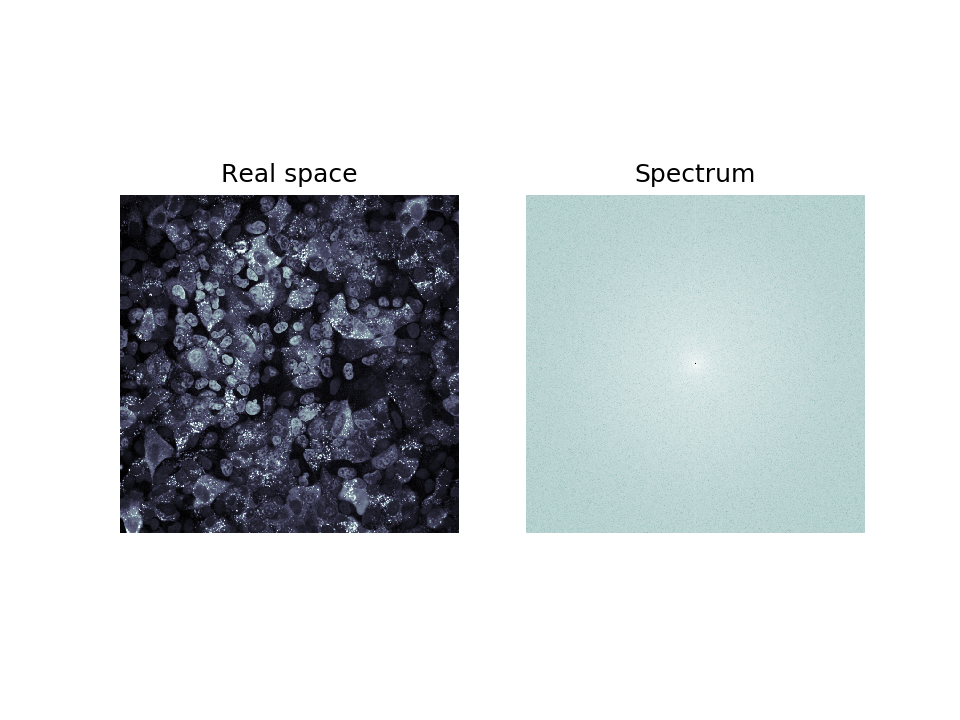

Text(0.5, 1.0, 'Spectrum')

In [14]:
phase_scale = 0.3
### YOUR PATH HERE ###
ground_truth_filepath = '/home/kellman/Workspace/DATA/cells/bigImgPhase.jpg'
img = mpimg.imread(ground_truth_filepath)[::3,::3,:]

# Phase only sample generator
img = np.mean(img[:,:,:2],axis=2)
img -= np.mean(img)
img /= np.max(img)
img *= phase_scale

# amplitude only sample generator
# img = np.mean(img[:,:,:2],axis=2)
# img /= np.max(img)
# img -= 1.
# img = 1. - img*0.3

plt.figure()
plt.subplot(121)
plt.imshow(img)
plt.axis('off')
plt.title('Real space')
plt.subplot(122)
plt.imshow(np.log10(np.abs(np.fft.fftshift(np.fft.fft2(img)))))
plt.axis('off')
plt.title('Spectrum')

## Simulation measurements

In [16]:
Nexamples = 100
exp_c  = pytorch_complex.ComplexExp().apply
sim = network.grad.generateSingleMeas # alias single LED simulation function
Nstart = [0, 0]
clean = torch.zeros(Nexamples, Nleds, Np[0], Np[1], device=device, dtype = torch.float32)
truth = torch.zeros(Nexamples, Np[0], Np[1], 2, device=device, dtype = torch.float32)

# simulate measurements
for ff in range(Nexamples):
    Nstart[0] = np.random.randint(img.shape[0]-Np[0])
    Nstart[1] = np.random.randint(img.shape[1]-Np[1])
    img_crop = img[Nstart[0]:Nstart[0] + Np[0], Nstart[1]:Nstart[1] + Np[1]]
    amplitude = torch.from_numpy(img_crop.astype(np.float32)).to(device)
    phase = torch.zeros_like(amplitude).to(device)
    complex_field = exp_c(torch.stack((amplitude, phase),axis=2)).to(device)
    clean[ff,...] = sim(complex_field, device = device)
    truth[ff,...] = complex_field

In [17]:
# add noise
noise_std = 0.005
noisy = np.random.normal(clean.cpu().numpy(),noise_std * np.sqrt(clean.cpu().numpy()))
noisy = np.clip(noisy,0., np.infty)

(100, 89, 40, 40)


<IPython.core.display.Javascript object>


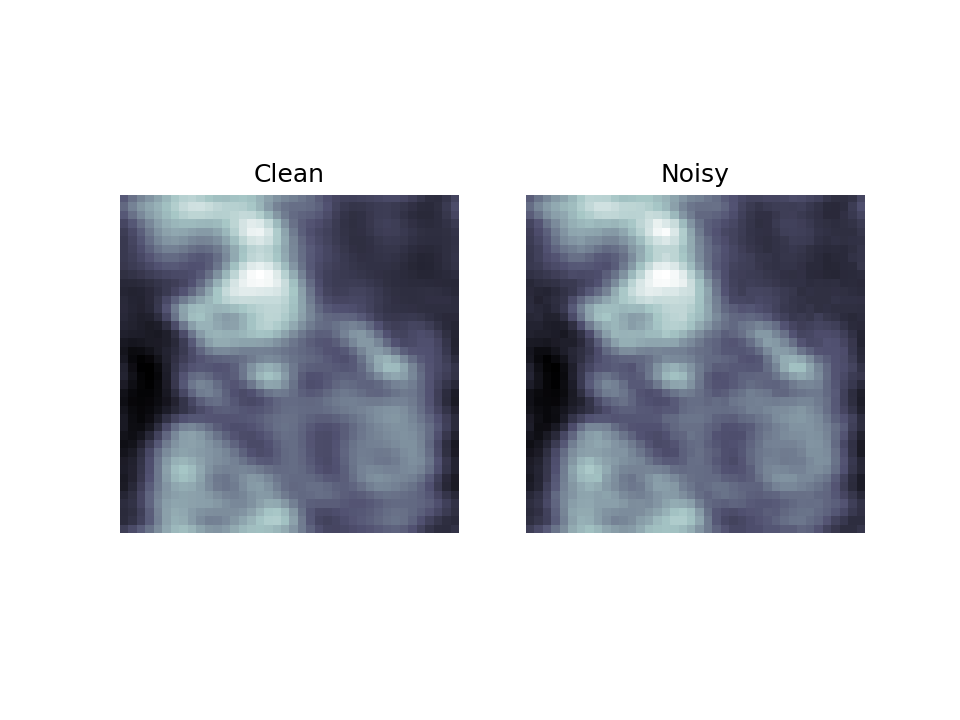

Text(0.5, 1.0, 'Noisy')

In [18]:
print(noisy.shape)
example = 0
index = 10
plt.figure()
plt.subplot(121)
plt.imshow(clean[example, index, ...].cpu().numpy())
plt.axis('off')
plt.title('Clean')
plt.subplot(122)
plt.imshow(noisy[example, index, ...])
plt.axis('off')
plt.title('Noisy')

torch.Size([89, 40, 40])


<IPython.core.display.Javascript object>


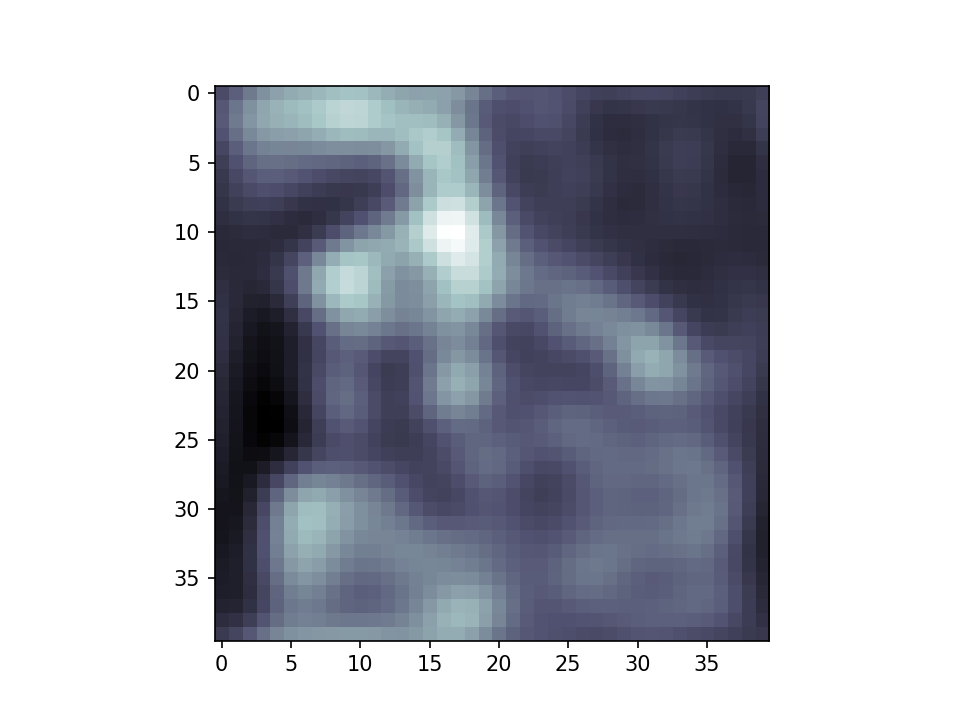

In [22]:
example = 0
print(clean[example,...].to(device).shape)
xtest = network.initialize(clean[example:example+1,...].to(device), device=device)
plt.figure()
plt.imshow(xtest.cpu().numpy()[...,0])

In [25]:
network.grad.C.data = torch.from_numpy(np.eye(Nleds).astype(np.float32)).to(device)
with torch.no_grad():
    x_ld, _ = evaluate(network.network, xtest)

<IPython.core.display.Javascript object>


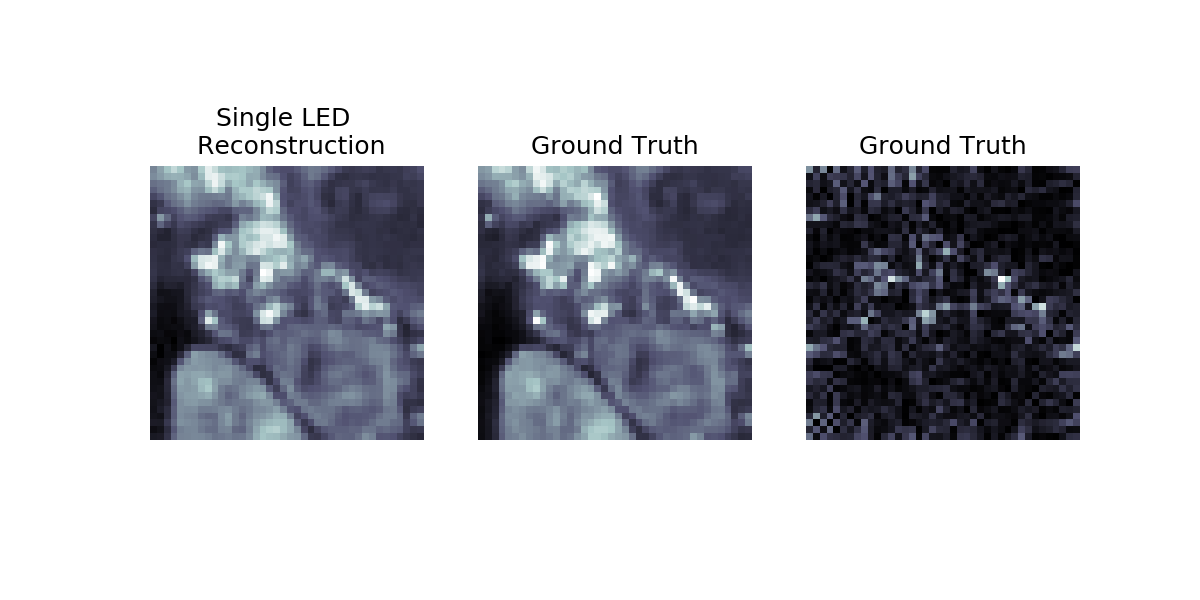

(-0.5, 39.5, 39.5, -0.5)

In [26]:
x_phase = getAbs(x_ld).cpu().numpy()
plt.figure(figsize=(8,4))
plt.subplot(131)
plt.imshow(x_phase)
plt.title('Single LED \n Reconstruction')
plt.axis('off')

plt.subplot(132)
truth_phase = getAbs(truth[example,...]).cpu().numpy()
plt.imshow(truth_phase)
plt.title('Ground Truth')
plt.axis('off')


plt.subplot(133)
error_phase = np.abs(truth_phase - x_phase)
plt.imshow(error_phase)
plt.title('Ground Truth')
plt.axis('off')

## Save dataset (batchwise save)

In [27]:
Nbatchsize = 25
batch_dir = 'test'
path = './data/' + batch_dir
!mkdir -p "$path"
for ii in range(Nexamples//Nbatchsize):
    start_idx = ii * Nbatchsize
    end_idx = (ii+1) * Nbatchsize
    datadict = {'noisy':noisy[start_idx:end_idx,...],
                     'clean':clean[start_idx:end_idx,...],
                     'truth':truth.cpu().numpy()[start_idx:end_idx,...]}
    sio.savemat(path + '/batch{0:02d}.mat'.format(ii),datadict)
sio.savemat(path + '/metadata.mat',metadata)